2022年香港中文大学的论文《Are Transformers Effective for Time Series Forecasting?》仅仅用最简单的Linear模型就结结实实的打脸了一众Transformer-based 模型，

最尴尬的是，在汇率预测上，一个简单的用昨天预测今天，或者上一个周期预测下一个周期的策略竟然比所有Transformer模型都表现得更好。这不禁让人怀疑，这些所谓的Transformer based究竟是在真的学习序列特征，还是只是在过拟合噪声，然后选择拟合的比较好的那些发表。

Transformer在NLP中的成功是基于其提取序列元素间语义相关性的能力。然而，时间序列数据本身通常缺乏语义，其核心在于建模连续点集中的时间关系，其中序列本身扮演着最关键的角色。

在自然语言中，即使完全打乱单词顺序，单纯的词义就可以反映相当多的原句的语义，Tramsformer模型再利用位置编码，建模词义之间的相对关系所带来的深层词义，来完成整个句子语义的处理。虽然位置编码可以保留一部分序列信息，但总归是有转换和丢失的。

面对时序数据，一个完全被打乱的序列，几乎丢掉了99%的信息，换言之时序数据的信息大部分都隐藏在相关关系中。在这种情况下，再去强行追求former系的并行性，用低效率的位置编码尝试保留序列信息，相当于是买椟还珠，本末倒置了。堆叠各种复杂的模型，并不一定就能取得更优的效果，更多只是基于发论文视角的为了创新而创新。

因此，在dive into deep learning 的各种 “former” 之前，需要先用传统的统计学工具建立一个科学而合理的基线模型，来区分哪些是真正有价值的，哪些只是花里胡哨的。



In [33]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [34]:
from utils.random_split import RandomSplit
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain

In [35]:
data = pd.read_csv('data/market_state.csv', index_col='Unnamed: 0')
data['open_ih'] = (data['close_ih']  - data['close_ih'].mean()) / data['close_ih'].std()
data['high_ih'] = (data['high_ih']  - data['close_ih'].mean()) / data['close_ih'].std()
data['low_ih'] = (data['low_ih']  - data['close_ih'].mean()) / data['close_ih'].std()
data['close_ih'] = (data['close_ih']  - data['close_ih'].mean()) / data['close_ih'].std()
data['amount_ih'] = (data['amount_ih']  - data['amount_ih'].mean()) / data['amount_ih'].std()
data

,trade_date,open_ih,close_ih,high_ih,low_ih,change_ih,amount_ih,open_if,close_if,high_if,...,RSI_ic,amplitude_ic,amplitude_up_ic,amplitude_low_ic,amplitude_avg_ic,ATR_ic,alter_std,down_probability,middle_probability,up_probability
0,20170914,-0.417755,-0.417755,-0.355975,-0.434707,-14.8343,-0.935197,3843.5720,3829.9554,3854.4931,...,NaN,NaN,NaN,NaN,NaN,NaN,106.511406,0.327086,0.327232,0.345682
1,20170915,-0.430316,-0.430316,-0.404530,-0.454656,-4.4605,-0.721044,3826.1448,3831.2965,3843.2970,...,NaN,0.008960,-0.001300,0.010260,0.017920,NaN,108.159834,0.303358,0.321147,0.375494
2,20170918,-0.413983,-0.413983,-0.357991,-0.425186,5.8000,-0.681907,3832.9626,3843.1428,3862.3589,...,NaN,0.008053,0.007160,0.000893,0.016106,NaN,102.812068,0.308299,0.337761,0.353940
3,20170919,-0.423796,-0.423796,-0.377352,-0.449371,-3.4845,-0.904604,3849.8794,3832.1161,3857.3030,...,NaN,0.010421,0.001769,0.008652,0.020842,NaN,100.327455,0.297620,0.345125,0.357256
4,20170920,-0.446507,-0.446507,-0.411068,-0.448643,-8.0648,-1.051507,3830.1549,3842.4353,3850.9426,...,NaN,0.011913,0.008543,0.003370,0.023826,NaN,92.999264,0.318345,0.371502,0.310153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,20250911,0.455919,0.455919,0.456240,0.272102,43.4918,3.912317,4438.8390,4548.0345,4548.0345,...,215.788280,0.033679,0.027545,0.006134,0.067358,0.047593,449.933338,NaN,NaN,NaN
1860,20250912,0.414965,0.414965,0.500689,0.403827,-14.5432,3.560085,4544.5905,4521.9980,4564.6665,...,205.684240,0.012318,0.010874,0.001444,0.024635,0.043419,NaN,NaN,NaN,NaN
1861,20250915,0.398282,0.398282,0.460911,0.384486,-5.9243,2.547140,4534.8866,4533.0557,4566.9053,...,214.301509,0.006724,0.003797,0.002927,0.013448,0.037970,NaN,NaN,NaN,NaN
1862,20250916,0.356623,0.356623,0.433012,0.341062,-14.7932,2.857555,4539.9217,4523.3367,4552.4190,...,192.151230,0.016112,0.008135,0.007977,0.032224,0.036925,NaN,NaN,NaN,NaN


In [36]:
data_set = RandomSplit(data, 'cuda:0')
feature = ['open_ih', 'close_ih', 'high_ih', 'low_ih', 'amount_ih']
label = ['label_ih_ch_next_week', 'down_probability', 'middle_probability', 'up_probability']

data_set.set_output(feature, dtype = torch.float32, unfold = True)
data_set.set_output(label, dtype = torch.float32, unfold = False)
train_set, validation_set, test_set = data_set.get_split_data(700, 250, 250, 30)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size):
        super(DLinear, self).__init__()

        self.seq_len = seq_len # 输入序列的长度
        self.pred_len = pred_len # 预测序列的长度

        # Decompsition Kernel Size
        self.kernel_size = kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual # 是否为每个feature应用不同的参数
        self.channels = enc_in # feature的个数 例如OHLCV数据为5

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]

        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [38]:
class DLinearOutput(nn.Module):
    """循环神经网络模型"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size)
        self.flatten = nn.Flatten(start_dim = 1)
        # self.flatten = nn.Sequential(nn.Flatten(start_dim = 1), nn.Linear(enc_in * pred_len, enc_in * pred_len), nn.ReLU(), nn.Dropout(0.5))
        self.output = HybridDecoder(dim_state = enc_in * pred_len, init_prob = init_prob)

    def forward(self, x):
        # random_drop = np.random.randint(0, 20)
        # x = x[:,random_drop:,:]
        x = self.process(x)
        x = self.flatten(x)
        return self.output(x)

In [39]:
loss_fn = HybridLoss(alpha = 1e-3, delta = 1)
recorder = PredictionRecorder(is_logits = True)
animator = TrainAnimator(figsize=(12,6))

model = DLinearOutput(seq_len = 30, pred_len = 5, individual = True, enc_in = 5, kernel_size = 11, init_prob = [0.0, 1, 0.0]).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay = 1e-2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


Animator data has been reset.


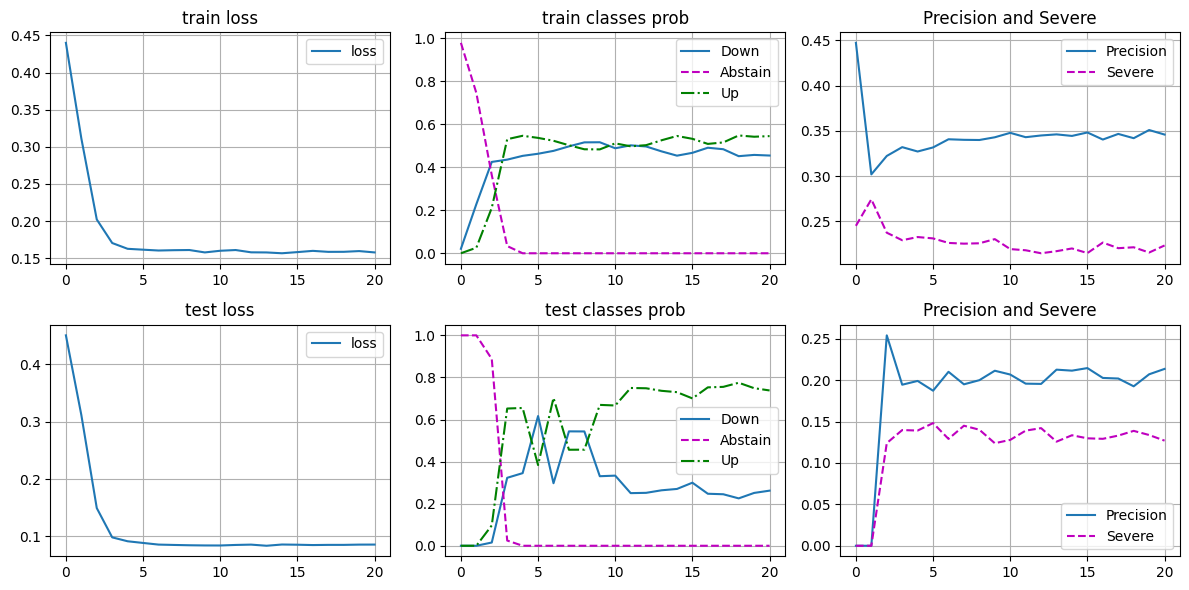

100%|██████████| 100/100 [00:00<00:00, 330.31it/s]


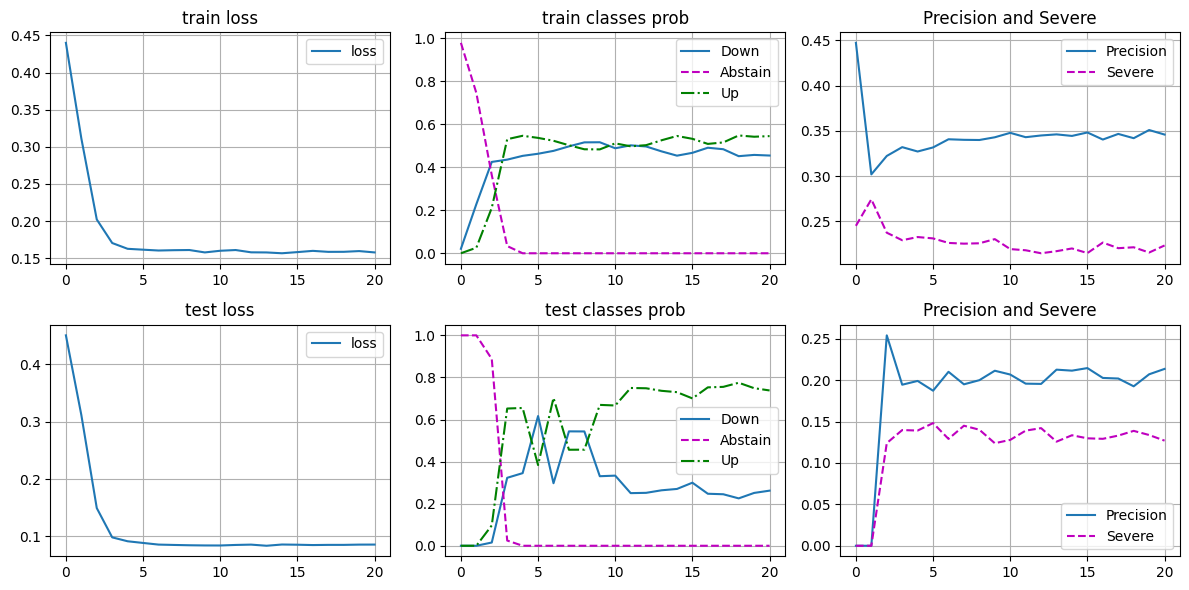

In [40]:
train = ModelTrain(model = model,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   threshold = 45,
                   )
train.epoch_train(epochs = 20, round = 100, early_stop = 30)

In [41]:
print(BackTest(model, *train_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'train', print_summary = True)

yearly return :25.55%
std           :91.81%
sharpe ratio  :0.25


100%|██████████| 100/100 [00:00<00:00, 303.77it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),48.34%,35.23%,22.20%,28.37%,60.03%
分类 1 (放弃),0.00%,0.00%,0.00%,43.04%,0.00%
分类 2 (乐观),51.66%,34.57%,21.95%,28.59%,62.47%
分类 0 + 分类 2,100.00%,34.89%,22.07%,56.96%,61.25%


In [42]:
print(BackTest(model, *validation_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'validation', print_summary = True)

yearly return :14.28%
std           :54.38%
sharpe ratio  :0.21


100%|██████████| 100/100 [00:00<00:00, 298.09it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),25.47%,37.34%,11.58%,19.40%,49.02%
分类 1 (放弃),0.00%,0.00%,0.00%,66.34%,0.00%
分类 2 (乐观),74.53%,15.18%,13.27%,14.26%,79.31%
分类 0 + 分类 2,100.00%,20.82%,12.84%,33.66%,61.85%


In [43]:
print(BackTest(model, *test_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'test', print_summary = True)

yearly return :18.25%
std           :82.13%
sharpe ratio  :0.19


100%|██████████| 100/100 [00:00<00:00, 303.37it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),48.49%,27.00%,17.39%,19.98%,65.52%
分类 1 (放弃),0.00%,0.00%,0.00%,61.16%,0.00%
分类 2 (乐观),51.51%,20.25%,13.38%,18.86%,55.30%
分类 0 + 分类 2,100.00%,23.52%,15.32%,38.84%,60.56%


In [44]:
# torch.save(model.state_dict(), 'params/baseline.params')